In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os

In [6]:
path_to_file = os.path.join('..', 'data', 'processed_data.csv')

df = pd.read_csv(path_to_file)

df = df[['SITE_ID', 'DATE_TIME', 'NO2']]

start_date = '2020-11-28 07:00:00'
end_date = '2023-11-28 18:00:00'

filter = (df['DATE_TIME'].between(start_date, end_date))
df = df[filter]

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')

site_id = 501
site_df = df[df['SITE_ID'] == site_id].copy()
site_df.set_index('DATE_TIME', inplace=True)
daily_df = site_df[['NO2']].resample('D').mean().interpolate(method='linear')
daily_df.dropna(inplace=True)

In [7]:

caz_launch_date = pd.to_datetime('2022-11-28')
train_data = daily_df[daily_df.index < caz_launch_date]
test_data = daily_df[daily_df.index >= caz_launch_date]

daily_df['is_post'] = (daily_df.index >= caz_launch_date).astype(int)

model = SARIMAX(train_data['NO2'],
                order=(2, 0, 1),
                seasonal_order=(0, 1, 0, 365),
                enforce_stationarity=False,
                enforce_invertibility=False)

dlm_result = model.fit(disp=False)

print("\n Dynamic Linear Model Analysis Summary:")
print(dlm_result.summary())


 Dynamic Linear Model Analysis Summary:
                                      SARIMAX Results                                       
Dep. Variable:                                  NO2   No. Observations:                  730
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 365)   Log Likelihood               -1651.902
Date:                              Sat, 13 Sep 2025   AIC                           3311.804
Time:                                      13:31:54   BIC                           3327.382
Sample:                                  11-28-2020   HQIC                          3317.996
                                       - 11-27-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2339      0.066     18.641      0.000   

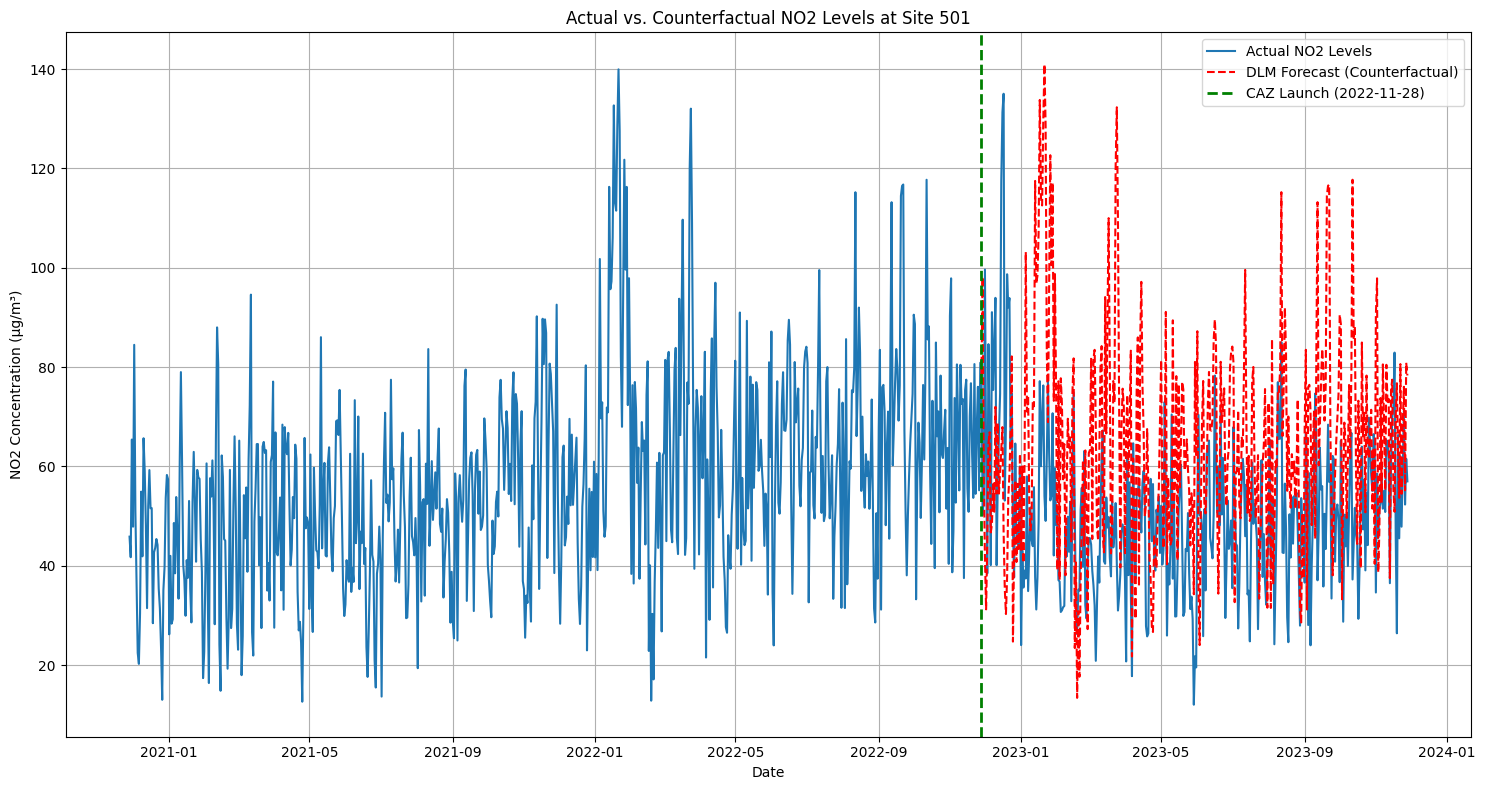

In [8]:
forecast = dlm_result.get_forecast(steps=len(test_data))
forecast_df = forecast.predicted_mean.to_frame(name='Forecast')
forecast_df.index = test_data.index

plt.figure(figsize=(15, 8))
plt.plot(daily_df['NO2'], label='Actual NO2 Levels')
plt.plot(forecast_df['Forecast'], color='red', linestyle='--', label='DLM Forecast (Counterfactual)')
plt.axvline(caz_launch_date, color='green', linestyle='--', linewidth=2, label='CAZ Launch (2022-11-28)')
plt.title(f'Actual vs. Counterfactual NO2 Levels at Site {site_id}')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('..', 'img', f'NO2_Levels_Site_{site_id}_DLM_Forecast.png'))
plt.show()